# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries as needed
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from itertools import accumulate
from pandas import DataFrame
from pylab import rcParams
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

# sagemaker libraries
import boto3
import os
import pickle
import sagemaker
from sagemaker import get_execution_role, LinearLearner
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.tuner import IntegerParameter, ContinuousParameter, CategoricalParameter, HyperparameterTuner

# custom libraries
from cleanupMethods import *

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
%%time

# fix some options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
rcParams['agg.path.chunksize'] = 10000

CPU times: user 73 µs, sys: 6 µs, total: 79 µs
Wall time: 84.9 µs


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [3]:
%%time

moTrain = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory = False)
moTest = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory = False)

CPU times: user 1.95 s, sys: 374 ms, total: 2.33 s
Wall time: 13.6 s


(42962, 367)


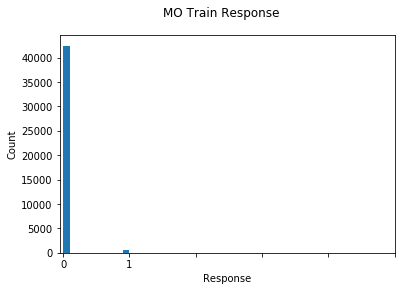

In [101]:
print(moTrain.shape)


## draw histograms for data

columnName = 'RESPONSE'
xLabelName = 'Response'
xTickString = ['0', '1']
arrangeData = 6
xLabel = 'Response'
yLabel = 'Count'

###

plt.hist(moTrain[columnName].values)
plt.xticks(np.arange(arrangeData), xTickString)
plt.suptitle('MO Train Response')
plt.xlabel(xLabel)
plt.ylabel(yLabel)
plt.show()

## very few customers, we need to make sure that doesnt throw us off

(42962, 367)


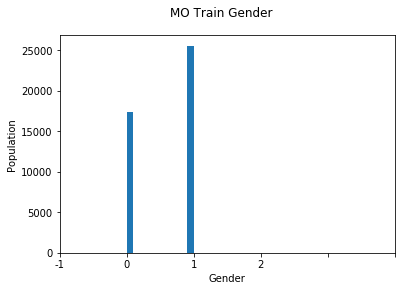

In [102]:
## Lets clean up the code first
#print(moTrain.head(15))
print(moTrain.shape)
#print(moTrain.describe())

## draw histograms for data

columnName = 'ANREDE_KZ'
xLabelName = 'Population'
xTickString = ['-1', '0', '1', '2']
arrangeData = 6
xLabel = 'Gender'
yLabel = 'Population'

###

plt.hist(moTrain[columnName].values)
plt.xticks(np.arange(arrangeData), xTickString)
plt.suptitle('MO Train Gender')
plt.xlabel(xLabel)
plt.ylabel(yLabel)
plt.show()

VisualizeNan
GetRowNanDistribution
(42962, 367)
Total:  7962
Total % at or above  30 %:  18.532656766444767
PrintUniqueValuesForColumns
LNR
0 ColumnName:  LNR UniqueLength 42962
Unique Values:  [ 1763  1771  1776 ... 68273 68581 69224]
AGER_TYP
1 ColumnName:  AGER_TYP UniqueLength 5
Unique Values:  [ 2  1  3 -1  0]
AKT_DAT_KL
2 ColumnName:  AKT_DAT_KL UniqueLength 10
Unique Values:  [ 1.  4. nan  7.  5.  9.  3.  2.  6.  8.]
ALTER_HH
3 ColumnName:  ALTER_HH UniqueLength 21
Unique Values:  [ 8. 13.  9.  6. 12. nan 15. 20. 21. 11. 19. 17. 10.  0.  5.  7. 16. 18.
 14.  4.  3.]
ALTER_KIND1
4 ColumnName:  ALTER_KIND1 UniqueLength 18
Unique Values:  [nan 13.  7. 14.  8. 18. 17.  9. 10. 16.  2. 15. 11. 12.  6.  5.  4.  3.]
ALTER_KIND2
5 ColumnName:  ALTER_KIND2 UniqueLength 15
Unique Values:  [nan 16. 15. 17. 10. 18.  9. 14. 12. 11. 13.  8.  7.  5.  6.]
ALTER_KIND3
6 ColumnName:  ALTER_KIND3 UniqueLength 13
Unique Values:  [nan 15. 18. 13. 10. 11. 16. 12. 17. 14.  6.  7.  8.]
ALTER_KIND4
7 Col

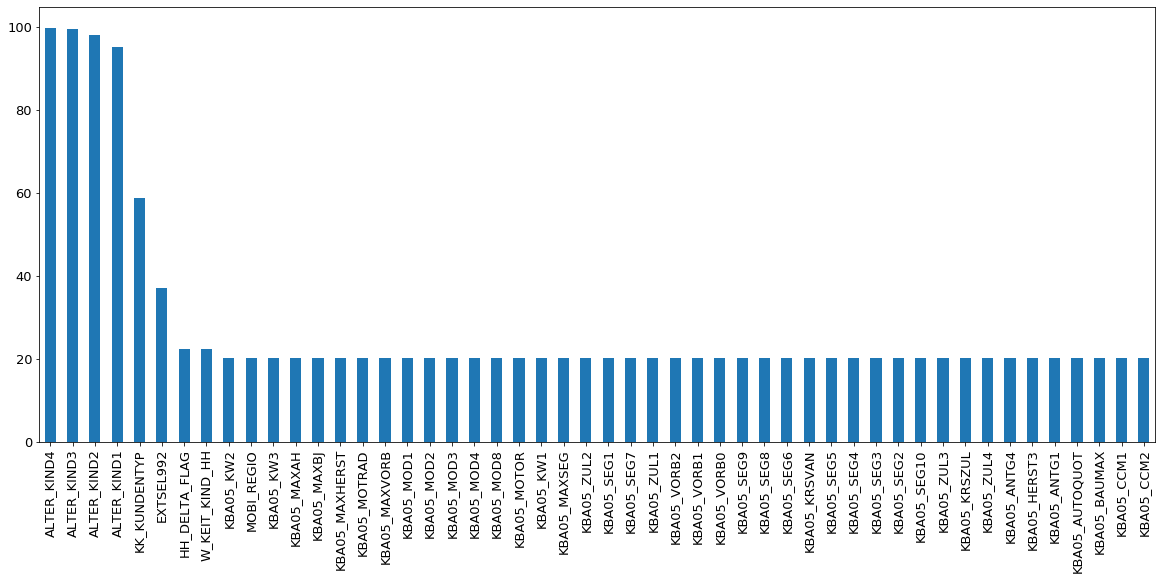

In [103]:
%%time

VisualizeNan(moTrain)

threshhold = 30
GetRowNanDistribution(moTrain, threshhold)

PrintUniqueValuesForColumns(moTrain)

VisualizeNan
CPU times: user 152 ms, sys: 0 ns, total: 152 ms
Wall time: 152 ms


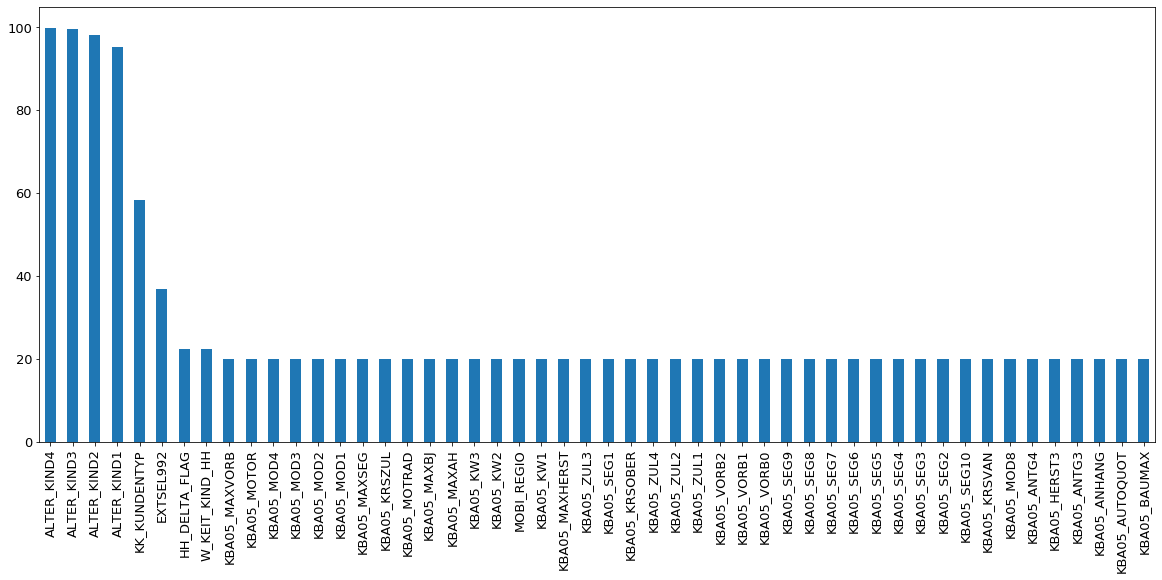

In [17]:
%%time

VisualizeNan(moTest)

In [104]:
%%time

moTrain = CleanDataBymarkingNaN(moTrain)
moTrain = CleanupCameo2015Extended(moTrain)

CleanDataBymarkingNaN
1 column header:  AGER_TYP
2 column header:  ALTERSKATEGORIE_GROB
3 column header:  ALTER_HH
4 column header:  ANREDE_KZ
5 column header:  BALLRAUM
6 column header:  BIP_FLAG
value not found:  -1
7 column header:  CAMEO_DEU_2015
value not found:  XX
8 column header:  CAMEO_DEUG_2015
value not found:  X
9 column header:  CAMEO_DEUINTL_2015
value not found:  -1
10 column header:  CAMEO_INTL_2015
value not found:  XX
11 column header:  CJT_GESAMTTYP
12 column header:  EWDICHTE
13 column header:  FINANZTYP
14 column header:  FINANZ_ANLEGER
15 column header:  FINANZ_HAUSBAUER
16 column header:  FINANZ_MINIMALIST
17 column header:  FINANZ_SPARER
18 column header:  FINANZ_UNAUFFAELLIGER
19 column header:  FINANZ_VORSORGER
20 column header:  GEBAEUDETYP
21 column header:  GEBURTSJAHR
22 column header:  GEOSCORE_KLS7
value not found:  -1
value not found:  0
23 column header:  HAUSHALTSSTRUKTUR
value not found:  -1
value not found:  0
24 column header:  HEALTH_TYP
25 column

In [105]:
%%time

threshhold = 33.33
moTrain = DropColumnsWithHigherNanPercentageThan(moTrain, threshhold)
print(moTrain.shape)

DropColumnsWithHigherNanPercentageThan
Column dropped:  ALTER_KIND4
Column dropped:  ALTER_KIND3
Column dropped:  TITEL_KZ
Column dropped:  ALTER_KIND2
Column dropped:  ALTER_KIND1
Column dropped:  KK_KUNDENTYP
Column dropped:  KBA05_BAUMAX
Column dropped:  AGER_TYP
Column dropped:  GEBURTSJAHR
Column dropped:  EXTSEL992
(42962, 357)
CPU times: user 72.7 ms, sys: 20.1 ms, total: 92.8 ms
Wall time: 90.3 ms


In [106]:
%%time

dropColumnsList = [
    #'ALTERSKATEGORIE_FEIN', # FEIN vs GROB
    'ANREDE_KZ', # only male and unknown gender, Gender
    'EINGEFUEGT_AM', # seems unnneded
    #'CAMEO_DEU_2015', # too many values
    #'D19_LETZTER_KAUF_BRANCHE', # too many values, Last Purchase Industry
    'LNR', # all unique values
    #'LP_FAMILIE_FEIN', # FEIN vs GROB
    #'LP_LEBENSPHASE_FEIN', # FEIN vs GROB
    #'LP_STATUS_FEIN', # FEIN vs GROB
    #'MIN_GEBAEUDEJAHR', # does not seem to be important
]
moTrain = DropMiscColumns(moTrain, dropColumnsList)
print(moTrain.shape)

DropMiscColumns
['ANREDE_KZ', 'EINGEFUEGT_AM', 'LNR']
(42962, 354)
(42962, 354)
CPU times: user 26.1 ms, sys: 20.1 ms, total: 46.2 ms
Wall time: 45.3 ms


In [107]:
%%time

threshhold = 30.0
GetRowNanDistribution(moTrain, threshhold)

moTrain = DropNanRowsAboveThreshhold(moTrain, threshhold)
print(moTrain.shape)

GetRowNanDistribution
(42962, 354)
Total:  7962
Total % at or above  30.0 %:  18.532656766444767
DropNanColumnAboveThreshhold
(35000, 354)
CPU times: user 213 ms, sys: 104 ms, total: 318 ms
Wall time: 315 ms


In [108]:
%%time

moTrain = BinaryEncode_OST_WEST_KZ_VERS_TYP(moTrain)

BinaryEncode_OST_WEST_KZ_VERS_TYP
CPU times: user 1.28 s, sys: 3.94 ms, total: 1.28 s
Wall time: 1.28 s


In [109]:
%%time

binaryValueColumns = [
    'GREEN_AVANTGARDE',
    'VERS_TYP',
    'OST_WEST_KZ'
]

categoricalValueColumns = [
    'CAMEO_DEU_2015', # Hexa
    'EINGEFUEGT_AM', # DateTime
    'D19_LETZTER_KAUF_BRANCHE', # Categorical
]

moTrain = ReplaceNans(moTrain, binaryValueColumns, categoricalValueColumns)

ReplaceNans
0 ColumnName:  AKT_DAT_KL
median value:  1.0
1 ColumnName:  ALTER_HH
median value:  11.0
2 ColumnName:  ALTERSKATEGORIE_FEIN
median value:  10.0
3 ColumnName:  ANZ_HAUSHALTE_AKTIV
median value:  2.0
4 ColumnName:  ANZ_HH_TITEL
median value:  0.0
5 ColumnName:  ANZ_KINDER
median value:  0.0
6 ColumnName:  ANZ_PERSONEN
median value:  2.0
7 ColumnName:  ANZ_STATISTISCHE_HAUSHALTE
median value:  2.0
8 ColumnName:  ANZ_TITEL
median value:  0.0
9 ColumnName:  ARBEIT
median value:  3.0
10 ColumnName:  BALLRAUM
median value:  5.0
11 ColumnName:  CAMEO_DEU_2015
Skipping due to being categorical
12 ColumnName:  CAMEO_DEUG_2015
median value:  5.0
13 ColumnName:  CAMEO_INTL_2015
median value:  32.0
14 ColumnName:  CJT_GESAMTTYP
median value:  2.0
15 ColumnName:  CJT_KATALOGNUTZER
median value:  4.0
16 ColumnName:  CJT_TYP_1
median value:  2.0
17 ColumnName:  CJT_TYP_2
median value:  2.0
18 ColumnName:  CJT_TYP_3
median value:  5.0
19 ColumnName:  CJT_TYP_4
median value:  5.0
20 ColumnN

In [110]:
%%time

## split
moTrain = Split4Columns(moTrain) 

Split4Columns
CPU times: user 9.59 s, sys: 2.73 s, total: 12.3 s
Wall time: 12.3 s


In [26]:
# one hot encoding
def HotEncodeColumns(df, columnsToEncode):
    '''
    One hot encode dataframe columns
    
    INPUT: 
        df: Dataframe to process
        columnsToEncode: columns that need to be hot encoded
        
    OUTPUT:
        Processed dataframe
    '''    
    print('HotEncodeColumns')
    print(df.shape)
    for (columnName, prefixName) in columnsToEncode.items():
        dfDummies = pd.get_dummies(df[columnName], prefix = prefixName)
        df = pd.concat([df, dfDummies], axis=1)
        df = df.drop(columns=[columnName])
    
    print(df.shape)
    return df

In [112]:
%%time

encodingColumns = {
    'D19_LETZTER_KAUF_BRANCHE' : 'LPI',
    'CAMEO_DEU_2015' : 'CD2015'
}

moTrain = HotEncodeColumns(moTrain, encodingColumns)

(35000, 359)
(35000, 436)
CPU times: user 176 ms, sys: 225 ms, total: 401 ms
Wall time: 399 ms


In [113]:
%%time

moTrain = ConvertToInt(moTrain)

ConvertToInt
CPU times: user 47.9 ms, sys: 12 ms, total: 59.9 ms
Wall time: 59 ms


In [118]:
%%time
excludedColumns = []
threshhold = 10
haha = RemoveOutliers(moTrain, excludedColumns, threshhold)


RemoveOutliers
(35000, 436)
(30255, 436)
CPU times: user 10.9 s, sys: 11.3 s, total: 22.2 s
Wall time: 22.2 s


In [20]:
%%time

PrintUniqueValuesForColumns(moTrain)

PrintUniqueValuesForColumns
LNR
0 ColumnName:  LNR UniqueLength 42962
Unique Values:  [ 1763  1771  1776 ... 68273 68581 69224]
AGER_TYP
1 ColumnName:  AGER_TYP UniqueLength 5
Unique Values:  [ 2  1  3 -1  0]
AKT_DAT_KL
2 ColumnName:  AKT_DAT_KL UniqueLength 10
Unique Values:  [ 1.  4. nan  7.  5.  9.  3.  2.  6.  8.]
ALTER_HH
3 ColumnName:  ALTER_HH UniqueLength 21
Unique Values:  [ 8. 13.  9.  6. 12. nan 15. 20. 21. 11. 19. 17. 10.  0.  5.  7. 16. 18.
 14.  4.  3.]
ALTER_KIND1
4 ColumnName:  ALTER_KIND1 UniqueLength 18
Unique Values:  [nan 13.  7. 14.  8. 18. 17.  9. 10. 16.  2. 15. 11. 12.  6.  5.  4.  3.]
ALTER_KIND2
5 ColumnName:  ALTER_KIND2 UniqueLength 15
Unique Values:  [nan 16. 15. 17. 10. 18.  9. 14. 12. 11. 13.  8.  7.  5.  6.]
ALTER_KIND3
6 ColumnName:  ALTER_KIND3 UniqueLength 13
Unique Values:  [nan 15. 18. 13. 10. 11. 16. 12. 17. 14.  6.  7.  8.]
ALTER_KIND4
7 ColumnName:  ALTER_KIND4 UniqueLength 12
Unique Values:  [nan 15. 18. 13. 11. 14. 17. 16.  6. 12.  7. 10.]
ALTE

In [3]:
def cleanMailOrderData(df, dropLNR, responsePresent):
    '''
    Clean the mail order dataframe
    
    INPUT: 
        df: Dataframe to process
        dropLNR: Drop LNR column or not (we may want to keep it around for the test part for Kaggle submission)
        responsePresent: Is 'RESPONSE' present as a column?
        
    OUTPUT:
        Processed dataframe
    '''
    
    # convert unknowns to NaN
    df = CleanDataBymarkingNaN(df)
    
    # convert unknowns to NaN and make all values int
    df = CleanupCameo2015Extended(df)

    # drop columns that have a higher % of NaNs than the threshhold
    threshold = 33.33
    df = DropColumnsWithHigherNanPercentageThan(df, threshold)
    print(df.shape)
    
    # drop specific columns  
    if dropLNR:
        dropColumnsList = [
            'ANREDE_KZ', # only male and unknown gender, Gender
            'EINGEFUEGT_AM', # seems unnneded
            'LNR', # all unique values
        ]
    else:
        dropColumnsList = [
            'ANREDE_KZ', # only male and unknown gender, Gender
            'EINGEFUEGT_AM', # seems unnneded
            #'LNR', # all unique values
        ]      
    df = DropMiscColumns(df, dropColumnsList)
    print(df.shape)      

    # drop rows that have NaN values more than the threshhold %
    threshhold = 33.33
    df = DropNanRowsAboveThreshhold(df, threshhold)
    print(df.shape)

    # binary encoder
    df = BinaryEncode_OST_WEST_KZ_VERS_TYP(df)

    # replace NaN values
    binaryValueColumns = [
        'GREEN_AVANTGARDE',
        'VERS_TYP',
        'OST_WEST_KZ'
    ]
    categoricalValueColumns = [
        'CAMEO_DEU_2015', # Hexa
        'EINGEFUEGT_AM', # DateTime
        'D19_LETZTER_KAUF_BRANCHE', # Categorical
    ]
    df = ReplaceNans(df, binaryValueColumns, categoricalValueColumns)

    # split some columns into multiple
    df = Split4Columns(df) 

    # hot encode categorical data
    encodingColumns = {
        'D19_LETZTER_KAUF_BRANCHE' : 'LPI',
        'CAMEO_DEU_2015' : 'CD2015'
    }
    df = HotEncodeColumns(df, encodingColumns)
    
    # convert to int
    df = ConvertToInt(df)
    
    # drop low variance, threshold of 0.5
    print(df.shape) 
    if dropLNR and responsePresent:
        dfResponse = df['RESPONSE']
        df = df.drop(columns = ['RESPONSE'])
    elif (not dropLNR) and responsePresent:
        dfResponse = df['RESPONSE', 'LNR']
        df = df.drop(columns = ['RESPONSE', 'LNR'])
    elif (not dropLNR) and (not responsePresent):
        dfResponse = df['LNR']
        df = df.drop(columns = ['LNR'])
    df = varianceThresholdDropper(df, 0.5)
    if not(dropLNR and (not responsePresent)):
        df = pd.concat([df, dfResponse], axis = 1)
        df.reset_index(drop=True, inplace=True)
    print(df.shape)
    
    # remove outliers
    excludedColumns = ['RESPONSE', 'LNR']
    threshold = 10
    df = RemoveOutliers(df, excludedColumns, threshold)
    df.reset_index(drop = True, inplace = True)
    
    # drop duplicates
    #df = df.drop_duplicates()
    
    return df    

In [4]:
def cleanMailOrderDataNoRowDrop(df, columnsToNotDrop):
    '''
    Clean the mail order dataframe
    
    INPUT: 
        df: Dataframe to process
        columnsToNotDrop: columns to not drop (not dropped for xMoTest - since the two datsets need to have the same number of features)
        
    OUTPUT:
        Processed dataframe
    '''
    
    # convert unknowns to NaN
    df = CleanDataBymarkingNaN(df)
    print('CleanDataBymarkingNaN', df.shape)   
    
    # convert unknowns to NaN and make all values int
    df = CleanupCameo2015Extended(df)
    print('CleanupCameo2015Extended', df.shape)  
    
    # drop columns that have a higher % of NaNs than the threshhold
    threshold = 33.33
    df = DropColumnsWithHigherNanPercentageThan(df, threshold)
    print('DropColumnsWithHigherNanPercentageThan', df.shape)
    
    # drop specific columns  
    dropColumnsList = [
        'ANREDE_KZ', # only male and unknown gender, Gender
        'EINGEFUEGT_AM', # seems unnneded
        #'LNR', # all unique values
    ]      
    df = DropMiscColumns(df, dropColumnsList)
    print('DropMiscColumns', df.shape)      

    # drop rows that have NaN values more than the threshhold %
    #threshhold = 33.33
    #df = DropNanRowsAboveThreshhold(df, threshhold)
    #print('DropNanRowsAboveThreshhold', df.shape)

    # binary encoder
    df = BinaryEncode_OST_WEST_KZ_VERS_TYP(df)
    print('BinaryEncode_OST_WEST_KZ_VERS_TYP', df.shape) 
    
    # replace NaN values
    binaryValueColumns = [
        'GREEN_AVANTGARDE',
        'VERS_TYP',
        'OST_WEST_KZ'
    ]
    categoricalValueColumns = [
        'CAMEO_DEU_2015', # Hexa
        'EINGEFUEGT_AM', # DateTime
        'D19_LETZTER_KAUF_BRANCHE', # Categorical
    ]
    df = ReplaceNans(df, binaryValueColumns, categoricalValueColumns)
    print('ReplaceNans', df.shape) 

    # split some columns into multiple
    df = Split4Columns(df) 
    print('Split4Columns', df.shape) 
    
    # hot encode categorical data
    encodingColumns = {
        'D19_LETZTER_KAUF_BRANCHE' : 'LPI',
        'CAMEO_DEU_2015' : 'CD2015'
    }
    df = HotEncodeColumns(df, encodingColumns)
    print('HotEncodeColumns', df.shape) 
    
    # convert to int
    df = ConvertToInt(df)
    print('ConvertToInt', df.shape) 
    
    # drop low variance, threshold of 0.5
    print(df.shape) 
    dfResponse = df['LNR']
    df = df.drop(columns = ['LNR'])
    for col in df.columns:
        print(col)
        if col not in columnsToNotDrop:
            df = df.drop(columns = [col])
    
    df = pd.concat([df, dfResponse], axis = 1)
    df.reset_index(drop = True, inplace = True)
    print('LowVarianceDrop', df.shape)
    
    return df     

In [5]:
%%time

moTrain = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory = False)
xMoTest = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory = False)

CPU times: user 2.07 s, sys: 348 ms, total: 2.42 s
Wall time: 2.42 s


In [11]:
%%time

print(xMoTrain.shape)
print(xMoTest.shape)

(34913, 315)
(42833, 315)
CPU times: user 204 µs, sys: 10 µs, total: 214 µs
Wall time: 160 µs


In [7]:
%%time

moTrain = cleanMailOrderData(moTrain, dropLNR = True, responsePresent = True)

yMoTrain = moTrain['RESPONSE']
xMoTrain = moTrain.drop(columns = ['RESPONSE'])

yMoTrain.reset_index(drop=True, inplace=True)
xMoTrain.reset_index(drop=True, inplace=True)

CleanDataBymarkingNaN
1 column header:  AGER_TYP
2 column header:  ALTERSKATEGORIE_GROB
3 column header:  ALTER_HH
4 column header:  ANREDE_KZ
5 column header:  BALLRAUM
6 column header:  BIP_FLAG
value not found:  -1
7 column header:  CAMEO_DEU_2015
value not found:  XX
8 column header:  CAMEO_DEUG_2015
value not found:  X
9 column header:  CAMEO_DEUINTL_2015
value not found:  -1
10 column header:  CAMEO_INTL_2015
value not found:  XX
11 column header:  CJT_GESAMTTYP
12 column header:  EWDICHTE
13 column header:  FINANZTYP
14 column header:  FINANZ_ANLEGER
15 column header:  FINANZ_HAUSBAUER
16 column header:  FINANZ_MINIMALIST
17 column header:  FINANZ_SPARER
18 column header:  FINANZ_UNAUFFAELLIGER
19 column header:  FINANZ_VORSORGER
20 column header:  GEBAEUDETYP
21 column header:  GEBURTSJAHR
22 column header:  GEOSCORE_KLS7
value not found:  -1
value not found:  0
23 column header:  HAUSHALTSSTRUKTUR
value not found:  -1
value not found:  0
24 column header:  HEALTH_TYP
25 column

In [10]:
%%time

lnrMoTest = xMoTest['LNR']

xMoTest = cleanMailOrderDataNoRowDrop(xMoTest, xMoTrain.columns)

xMoTest = xMoTest.drop(columns = ['LNR'])

CleanDataBymarkingNaN
1 column header:  AGER_TYP
2 column header:  ALTERSKATEGORIE_GROB
3 column header:  ALTER_HH
4 column header:  ANREDE_KZ
5 column header:  BALLRAUM
6 column header:  BIP_FLAG
value not found:  -1
7 column header:  CAMEO_DEU_2015
value not found:  XX
8 column header:  CAMEO_DEUG_2015
value not found:  X
9 column header:  CAMEO_DEUINTL_2015
value not found:  -1
10 column header:  CAMEO_INTL_2015
value not found:  XX
11 column header:  CJT_GESAMTTYP
12 column header:  EWDICHTE
13 column header:  FINANZTYP
14 column header:  FINANZ_ANLEGER
15 column header:  FINANZ_HAUSBAUER
16 column header:  FINANZ_MINIMALIST
17 column header:  FINANZ_SPARER
18 column header:  FINANZ_UNAUFFAELLIGER
19 column header:  FINANZ_VORSORGER
20 column header:  GEBAEUDETYP
21 column header:  GEBURTSJAHR
22 column header:  GEOSCORE_KLS7
value not found:  -1
value not found:  0
23 column header:  HAUSHALTSSTRUKTUR
value not found:  -1
value not found:  0
24 column header:  HEALTH_TYP
25 column

In [12]:
%%time

xMoTest.reset_index(drop=True, inplace=True)

CPU times: user 102 µs, sys: 5 µs, total: 107 µs
Wall time: 112 µs


In [13]:
%%time

(xMoTrain, scaler) = ScaleFeature(xMoTrain)


ScaleFeature
CPU times: user 194 ms, sys: 98.1 ms, total: 292 ms
Wall time: 291 ms


In [14]:
%%time

(xMoTest, scaler) = ScaleFeature(xMoTest)

ScaleFeature
CPU times: user 257 ms, sys: 93.5 ms, total: 351 ms
Wall time: 349 ms


In [15]:
%%time

# divide into test and train
xTrain, xTest, yTrain, yTest = train_test_split(xMoTrain, yMoTrain,
                                                test_size = 0.2, random_state = 71, shuffle = True, stratify = yMoTrain)


CPU times: user 71.7 ms, sys: 12.2 ms, total: 83.9 ms
Wall time: 84.6 ms


In [16]:
%%time

# ensure that data directory exists
dataDir = '../data/arvato'
if not os.path.exists(dataDir):
    os.makedirs(dataDir)

# save data as csv file
xMoTest.to_csv(os.path.join(dataDir, 'test.csv'), header = False, index = False)
pd.concat([yTest, xTest], axis = 1).to_csv(os.path.join(dataDir, 'validation.csv'), header = False, index = False)
pd.concat([yTrain, xTrain], axis = 1).to_csv(os.path.join(dataDir, 'train.csv'), header = False, index = False)

# sagemaker session, role
sagemakerSession = sagemaker.Session()
sagemakerRole = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemakerSession.default_bucket()

# output path
llPrefix = 'arvato-ll'
xgbPrefix = 'arvato-xgb'
llOutputPath = 's3://{}/{}/output'.format(bucket, llPrefix)
xgbOutputPath = 's3://{}/{}/output'.format(bucket, xgbPrefix)
llPredictedOutputPath = 's3://{}/{}/predictedOutput'.format(bucket, llPrefix)
xgbPredictedOutputPath = 's3://{}/{}/predictedOutput'.format(bucket, xgbPrefix)

# location for data input
prefix = 'data'
testLocation = sagemakerSession.upload_data(os.path.join(dataDir, 'test.csv'), key_prefix = prefix)
validationLocation = sagemakerSession.upload_data(os.path.join(dataDir, 'validation.csv'), key_prefix = prefix)
trainLocation = sagemakerSession.upload_data(os.path.join(dataDir, 'train.csv'), key_prefix = prefix)

# input data train
s3InputTrain = sagemaker.s3_input(s3_data=trainLocation, content_type = 'text/csv')
s3InputValidation = sagemaker.s3_input(s3_data=validationLocation, content_type = 'text/csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


CPU times: user 45.1 s, sys: 2.05 s, total: 47.1 s
Wall time: 51 s


In [17]:
%%time

lLearner = sagemaker.estimator.Estimator(
    get_image_uri(sagemakerSession.boto_region_name, 'linear-learner'),
    sagemakerRole,
    train_instance_count = 1,
    train_instance_type = 'ml.m4.xlarge',
    output_path = llOutputPath,
    sagemaker_session = sagemakerSession)

lLearner.set_hyperparameters(
    predictor_type = 'binary_classifier',
    binary_classifier_model_selection_criteria = 'accuracy',
    normalize_data = True,
    positive_example_weight_mult = 'balanced',
    optimizer = 'adam',
    l1 = 0.1,
    wd = 0.1)

linearHyperparameterRanges = {
    'learning_rate' : ContinuousParameter(0.1, 0.5),
    'mini_batch_size' : IntegerParameter(300, 1000),
    'use_bias' : CategoricalParameter([True, False])}

linearHyperparameterTuner = HyperparameterTuner(
    lLearner,
    'test:binary_classification_accuracy',                            
     linearHyperparameterRanges,
     max_jobs = 12,
     max_parallel_jobs = 3)          

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


CPU times: user 14.4 ms, sys: 34 µs, total: 14.4 ms
Wall time: 13.8 ms


In [18]:
%%time

linearHyperparameterTuner.fit({'train': s3InputTrain, 'test': s3InputValidation})
linearHyperparameterTuner.wait()

....................................................................................................................................................................................................................................!
CPU times: user 1.36 s, sys: 32.7 ms, total: 1.39 s
Wall time: 19min 13s


In [19]:
%%time

bestLLearnerAttached = lLearner.attach(linearHyperparameterTuner.best_training_job())

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-08-03 04:25:49 Starting - Preparing the instances for training
2020-08-03 04:25:49 Downloading - Downloading input data
2020-08-03 04:25:49 Training - Training image download completed. Training in progress.
2020-08-03 04:25:49 Uploading - Uploading generated training model
2020-08-03 04:25:49 Completed - Training job completedDocker entrypoint called with argument(s): train
Running default environment configuration script
[08/03/2020 04:24:49 INFO 139744491317056] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform

In [20]:
%%time

lLearnerTransformer = bestLLearnerAttached.transformer(
    instance_count = 1,
    instance_type = 'ml.m5.xlarge',
    output_path = llPredictedOutputPath)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


CPU times: user 21.2 ms, sys: 0 ns, total: 21.2 ms
Wall time: 352 ms


In [22]:
%%time

lLearnerTransformer.transform(
    data = testLocation,
    data_type = 'S3Prefix',
    content_type = 'text/csv',
    split_type = 'Line')
lLearnerTransformer.wait()

..................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[08/03/2020 04:44:18 INFO 139627127908160] loaded entry point class algorithm.serve.server_config:config_api
[08/03/2020 04:44:18 INFO 139627127908160] loading entry points
[08/03/2020 04:44:18 INFO 139627127908160] loaded request iterator text/csv
[08/03/2020 04:44:18 INFO 139627127908160] loaded request iterator application/x-recordio-protobuf
[08/03/2020 04:44:18 INFO 139627127908160] loaded request iterator application/json
[08/03/2020 04:44:18 INFO 139627127908160] loaded request iterator application/jsonlines
[08/03/2020 04:44:18 INFO 139627127908160] loaded response encoder text/csv
[08/03/2020 04:44:18 INFO 139627127908160] loaded response encoder application/x-recordio-protobuf
[08/03/2020 04:44:18 INFO 139627127908160] loaded response encoder application/json
[08/03/2020 04:44:18 INFO 139627127908160] loaded response encoder application/jsonlines
[08/03/2020 04:

In [55]:
%%time

xgb = sagemaker.estimator.Estimator(
    get_image_uri(sagemakerSession.boto_region_name, 'xgboost'),
    sagemakerRole,
    train_instance_count = 1,
    train_instance_type = 'ml.m5.xlarge',
    output_path = xgbOutputPath,
    sagemaker_session = sagemakerSession)

xgb.set_hyperparameters(
    #max_depth = 5,
    #eta = 0.2,
    #gamma = 4,
    #min_child_weight = 6,
    #subsample = 0.8,
    objective = 'binary:logistic',
    early_stopping_rounds = 10,
    #alpha = 0.1,#scale_pos_weight = 1,
    #num_round = 400
)

xgbHyperparameterRanges = {
    'alpha' : IntegerParameter(0, 100),
    'eta' : ContinuousParameter(0.1, 0.5),
    'gamma' : IntegerParameter(0, 50),
    'lambda' : IntegerParameter(0, 100),
    'max_depth' : IntegerParameter(2, 10),
    'min_child_weight' : IntegerParameter(2, 100),
    'num_round' : IntegerParameter(100, 5000),
    'subsample' : ContinuousParameter(0.3, 1.0) }

xgbHyperparameterTuner = HyperparameterTuner(
    xgb,
    'validation:auc',
    xgbHyperparameterRanges,
    max_jobs = 21,
    max_parallel_jobs = 3)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


CPU times: user 14 ms, sys: 82 µs, total: 14.1 ms
Wall time: 15.8 ms


In [56]:
%%time

xgbHyperparameterTuner.fit({'train': s3InputTrain, 'validation': s3InputValidation})
xgbHyperparameterTuner.wait()

...........................................................................................................................................................................................................................................................!
CPU times: user 1.5 s, sys: 41.8 ms, total: 1.55 s
Wall time: 21min 8s


In [57]:
%%time

bestXgbAttached = xgb.attach(xgbHyperparameterTuner.best_training_job())

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-08-03 06:46:35 Starting - Preparing the instances for training
2020-08-03 06:46:35 Downloading - Downloading input data
2020-08-03 06:46:35 Training - Training image download completed. Training in progress.
2020-08-03 06:46:35 Uploading - Uploading generated training model
2020-08-03 06:46:35 Completed - Training job completedArguments: train
[2020-08-03:06:46:22:INFO] Running standalone xgboost training.
[2020-08-03:06:46:22:INFO] Setting up HPO optimized metric to be : auc
[2020-08-03:06:46:22:INFO] File size need to be processed in the node: 207.01mb. Available memory size in the node: 8149.09mb
[2020-08-03:06:46:22:INFO] Determined delimiter of CSV input is ','
[06:46:22] S3DistributionType set as FullyReplicated
[06:46:23] 27930x315 matrix with 8797950 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-08-03:06:46:23:INFO] Determined delimiter of CSV input is ','
[06:46:23] S3DistributionType set as FullyReplicated
[06:46:23] 6983x315 ma

In [58]:
%%time

xgbTransformer = bestXgbAttached.transformer(
    instance_count = 1,
    instance_type = 'ml.m4.xlarge',
    output_path = xgbPredictedOutputPath)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


CPU times: user 7.63 ms, sys: 4.01 ms, total: 11.6 ms
Wall time: 340 ms


In [59]:
%%time

xgbTransformer.transform(
    testLocation,
    content_type = 'text/csv',
    split_type = 'Line')
xgbTransformer.wait()

........................Arguments: serve
[2020-08-03 07:02:41 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-08-03 07:02:41 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-08-03 07:02:41 +0000] [1] [INFO] Using worker: gevent
[2020-08-03 07:02:41 +0000] [37] [INFO] Booting worker with pid: 37
[2020-08-03 07:02:41 +0000] [38] [INFO] Booting worker with pid: 38
[2020-08-03 07:02:41 +0000] [39] [INFO] Booting worker with pid: 39
[2020-08-03 07:02:41 +0000] [40] [INFO] Booting worker with pid: 40
[2020-08-03:07:02:41:INFO] Model loaded successfully for worker : 38
[2020-08-03:07:02:41:INFO] Model loaded successfully for worker : 37
[2020-08-03:07:02:41:INFO] Model loaded successfully for worker : 40
[2020-08-03:07:02:41:INFO] Model loaded successfully for worker : 39

[2020-08-03:07:03:06:INFO] Sniff delimiter as ','
[2020-08-03:07:03:06:INFO] Determined delimiter of CSV input is ','
[2020-08-03:07:03:06:INFO] Sniff delimiter as ','
[2020-08-03:07:03:06:INFO] Determined del

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
## Output file from above were downloaded and renamed as per expectation in the cell below. 
## And re-uploaded to the sagemaker instance.

In [60]:
%%time

xgbOut = pd.read_csv('xgb_out.csv', sep=';', low_memory = False, header = None)
llOut = pd.read_csv('ll_out.csv', sep=';', low_memory = False, header = None)

CPU times: user 9.98 ms, sys: 82 µs, total: 10.1 ms
Wall time: 9.27 ms


In [26]:
%%time

predictedLabels = []

import ast

for index, row in llOut.iterrows():
    rr = row['{"predicted_label":0,"score":0.008471053093671}']
    dict = ast.literal_eval(rr)
    predictedLabels.append(dict.get("predicted_label"))


Index(['{"predicted_label":0,"score":0.008471053093671}'], dtype='object')
CPU times: user 7.14 s, sys: 0 ns, total: 7.14 s
Wall time: 7.14 s


In [27]:
%%time

resultDf = DataFrame(predictedLabels, columns=['RESPONSE'])

resultLNR = lnrMoTest

print('resultDf', resultDf.shape)
print('LNR', resultLNR.shape)

resultDf = ConvertToInt(resultDf)
resultLNR = ConvertToInt(resultLNR)
resultDf.reset_index(drop=True, inplace=True)
resultLNR.reset_index(drop=True, inplace=True)
sendDf = pd.concat([resultDf, resultLNR], axis = 1)

sendDf.to_csv('ll_out_processed.csv', index = False)

resultDf (42832, 1)
LNR (42833,)
ConvertToInt
ConvertToInt
   RESPONSE   LNR
0       0.0  1754
1       0.0  1770
2       0.0  1465
3       0.0  1470
4       0.0  1478
CPU times: user 96.5 ms, sys: 0 ns, total: 96.5 ms
Wall time: 95.4 ms


In [63]:
%%time

resultLNR = lnrMoTest

xgbOut.reset_index(drop=True, inplace=True)
resultLNR.reset_index(drop=True, inplace=True)
sendDf = pd.concat([resultLNR, xgbOut], axis = 1)

sendDf.to_csv('xgb_out_processed.csv', index = False)

(42833, 2)
CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 126 ms
